<a href="https://colab.research.google.com/github/bengsoon/Fender/blob/main/Predicting_Oil_Production_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Production Forecast

The idea to this repository is to create a "virtual meter" that acts as a second opinion to the measurements obtained from either Multiphase Flow Meter (MPFM) or periodic welltest operations (through test separators) by taking account into the totality of each well parameters on the platform.

### Why Not Nodal Analysis? 
Conventionally, physics-based simulation models like Nodal Analysis look at a limited framework of the wells itself, as accurate as that can be (and still is an ideal way of well modeling for Petroleum Engineers), it does not scale up well to bring in a holistic consideration of the whole production operation - such as effects of neighboring wells, backpressures from the downstream etc. 

Not only that, the process of building physics-based models like Nodal Analysis requires extensive (and not to mention, expensive) subsurface data such as fluid tests, fluid levels, downhole pressures, some of which are obtained only once  during the whole life of the field. However, subsurface (and surface, for that matter), parameters dynamically change at different phases of the field life.

Having an ML model that is adaptable and scalable to the dynamic changes of the operation can at least serve as a second opinion on top of the industry-standard physics-based models.

### Downside of ML models
As much as it can bring value, it must also be noted that there are definitely downsides to ML models. Because ML models basically brings correlations between different signals from the data to the dependent / target variable (in this case, Oil Production value), it is only as good as the data can get. There is a risk that the model prediction is "unreasonble" or "non-physical" as an ML model does not understand the "physical" boundaries of the problem. Much care must be taken for this. 

As such, it is not recommended that we use ML models for the purposes where accuracies are expected and required such as reserves reporting, in which case the true and tested physics-based models should be used.

### This notebook

The notebook consists of a walkthrough / **EDA** of the Volve production dataset and then exploring tree-based algorithms starting from the simplest **Decision Tree**, followed by **Random Forest** and then finally **XGBoost**.

In the XGBoost section, I also explored **Hyperparameter Grid Search** to search the optimal values to tune the XGBoost model. Finally, I performed **Feature Selection** using the feature importance tool in the XGBoost model before finalizing it.

# Strategy

The dataset used in this notebook is the Volve Production Data by Equinor. You can either directly pull the dataset from the Github repo of this project or from the Equinor's [website](https://www.equinor.com/en/what-we-do/digitalisation-in-our-dna/volve-field-data-village-download.html) itself.

The purpose of this project is to predict the daily Oil Production (labeled as `BORE_OIL_VOL` in the dataset) of one of the seven wells in the Volve Production data, specifically the `15/9-F-1 C` well using machine learning algorithms.

Target Variable: `BORE_OIL_VOL` for `15/9-F-1 C`

### This Notebook
The notebook consists of a walkthrough / **EDA** of the Volve production dataset and then exploring tree-based algorithms starting from the simplest **Decision Tree**, followed by **Random Forest** and then finally **XGBoost**.

In the XGBoost section, I also explored **Hyperparameter Grid Search** to search the optimal values to tune the XGBoost model. Finally, I performed **Feature Selection** using the feature importance tool in the XGBoost model before finalizing it.

# Random Forest to Predict Oil Production 
### with Volve Production Data (at well level for `15/9-F-1 C` well)
This exercise looks into two data science models in order to predict oil production, namely Random Forest/Linear Regression

The idea is to be able to have different "well parameters" (tubing head pressure, tubing head temperature, downhole pressure and temperature, choke sizes, annulus pressure, neighboring well parameters etc) and then see if it affects a particular well's Oil Production (**Borehole Oil Volume** `BORE_OIL_VOL`)

A lot of the pre-processing methodology and workflow as well as the Random Forest were adapted from fastai's `fastbook`, chapter 9 on Tabular Data (https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb)

In [ ]:
!pip install -Uqq fastbook waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.6MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
     |████████████████████████████████| 1.2MB 42.6MB/s 
     |████████████████████████████████| 194kB 51.6MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 61kB 10.7MB/s 
     |████████████████████████████████| 61kB 11.5MB/s 


In [ ]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

import seaborn as sns

pd.options.display.max_robws = 100
pd.options.display.max_columns = 100

%matplotlib inline

# Loading Data

In [ ]:
df = pd.read_excel(".\data\Volve production data.xlsx", parse_dates=True)
df.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_DP_TUBING,AVG_ANNULUS_PRESS,AVG_CHOKE_SIZE_P,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,0.00000,0.00000,0.0,0.000000,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,NaN,NaN,0.0,1.003059,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,NaN,NaN,0.0,0.979008,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,NaN,NaN,0.0,0.545759,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,96.87589,277.27826,0.0,1.215987,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


In [ ]:
df.columns

Index(['DATEPRD', 'WELL_BORE_CODE', 'NPD_WELL_BORE_CODE', 'NPD_WELL_BORE_NAME',
       'NPD_FIELD_CODE', 'NPD_FIELD_NAME', 'NPD_FACILITY_CODE',
       'NPD_FACILITY_NAME', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE',
       'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS',
       'AVG_CHOKE_SIZE_P', 'AVG_CHOKE_UOM', 'AVG_WHP_P', 'AVG_WHT_P',
       'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
       'BORE_WI_VOL', 'FLOW_KIND', 'WELL_TYPE'],
      dtype='object')

The original Volve production data excel file contains the data for each day with several columns that were redundant (such as "Field Name"; which is pretty much "Volve", or "Platform Name" etc). 

To visualize the table better, I used Google Sheet to skim through the data to ensure that this was the case.

In [ ]:
# these are the columns that we will not need as they are redundant for our evaluation
remove_cols = ['WELL_BORE_CODE', 'NPD_WELL_BORE_CODE', 'NPD_FIELD_CODE', 'NPD_FIELD_NAME', 'NPD_FACILITY_CODE', 'NPD_FACILITY_NAME','AVG_CHOKE_UOM', 'DP_CHOKE_SIZE', 'WELL_TYPE']

In [ ]:
df = df.drop(columns = remove_cols)

In [ ]:
# Let's check what columns we have and the datatypes in each of them
for col in df.columns:
    print(col,": ", df[col].dtype )

DATEPRD :  datetime64[ns]
NPD_WELL_BORE_NAME :  object
ON_STREAM_HRS :  float64
AVG_DOWNHOLE_PRESSURE :  float64
AVG_DOWNHOLE_TEMPERATURE :  float64
AVG_DP_TUBING :  float64
AVG_ANNULUS_PRESS :  float64
AVG_CHOKE_SIZE_P :  float64
AVG_WHP_P :  float64
AVG_WHT_P :  float64
BORE_OIL_VOL :  float64
BORE_GAS_VOL :  float64
BORE_WAT_VOL :  float64
BORE_WI_VOL :  float64
FLOW_KIND :  object


In [ ]:
for col in df.columns:
  print(col)

DATEPRD
NPD_WELL_BORE_NAME
ON_STREAM_HRS
AVG_DOWNHOLE_PRESSURE
AVG_DOWNHOLE_TEMPERATURE
AVG_DP_TUBING
AVG_ANNULUS_PRESS
AVG_CHOKE_SIZE_P
AVG_WHP_P
AVG_WHT_P
BORE_OIL_VOL
BORE_GAS_VOL
BORE_WAT_VOL
BORE_WI_VOL
FLOW_KIND


In [ ]:
# Let's change the column labels to clearer and shorter descriptive labels

# preparing new labels 
old_labels = tuple(df.columns)
new_labels = ('DATE','WELL','HOURS','DH_PRESS','DH_TEMP','DP_TUBING','ANN_PRESS','CHOKE_SIZE','THP','WHT','OIL','GAS','WAT','WI','TYPE')

column_dict = {old_labels[i]: new_labels[i] for i in range(len(old_labels))}

df = df.rename(columns=column_dict); df.head()

,DATE,WELL,HOURS,DH_PRESS,DH_TEMP,DP_TUBING,ANN_PRESS,CHOKE_SIZE,THP,WHT,OIL,GAS,WAT,WI,TYPE
0,2014-04-07,15/9-F-1 C,0.0,0.00000,0.00000,0.00000,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.0,NaN,production
1,2014-04-08,15/9-F-1 C,0.0,NaN,NaN,NaN,0.0,1.003059,0.00000,0.00000,0.0,0.0,0.0,NaN,production
2,2014-04-09,15/9-F-1 C,0.0,NaN,NaN,NaN,0.0,0.979008,0.00000,0.00000,0.0,0.0,0.0,NaN,production
3,2014-04-10,15/9-F-1 C,0.0,NaN,NaN,NaN,0.0,0.545759,0.00000,0.00000,0.0,0.0,0.0,NaN,production
4,2014-04-11,15/9-F-1 C,0.0,310.37614,96.87589,277.27826,0.0,1.215987,33.09788,10.47992,0.0,0.0,0.0,NaN,production


## Types of Wells

In [ ]:
df["WELL"].unique()

array(['15/9-F-1 C', '15/9-F-11', '15/9-F-12', '15/9-F-14', '15/9-F-15 D', '15/9-F-4', '15/9-F-5'], dtype=object)

For simplicity sake, let's truncate the well names from `15/9-F-* *` into something clearer and simpler like `F-1 C` or `F-11` or `F-12`....

In [ ]:
df["WELL"] = df["WELL"].apply(lambda x: x.replace("15/9-", "")); 
df["WELL"].unique()

array(['F-1 C', 'F-11', 'F-12', 'F-14', 'F-15 D', 'F-4', 'F-5'], dtype=object)

## Outliers & Missing Data

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
HOURS,15349.0,19.994093,8.369978,0.00,24.000000,24.000000,24.000000,25.000000
DH_PRESS,8980.0,181.803869,109.712363,0.00,0.000000,232.896939,255.401455,397.588550
DH_TEMP,8980.0,77.162969,45.657948,0.00,0.000000,103.186689,106.276591,108.502178
DP_TUBING,8980.0,154.028787,76.752373,0.00,83.665361,175.588861,204.319964,345.906770
ANN_PRESS,7890.0,14.856100,8.406822,0.00,10.841437,16.308598,21.306125,30.019828
CHOKE_SIZE,8919.0,55.168533,36.692924,0.00,18.952989,52.096877,99.924288,100.000000
THP,9155.0,45.377811,24.752631,0.00,31.148062,37.933620,57.101268,137.311030
WHT,9146.0,67.728440,27.719028,0.00,56.577834,80.071250,88.062202,93.509584
OIL,9161.0,1095.631548,1323.538151,0.00,190.690000,557.550000,1345.200000,5901.840000
GAS,9161.0,161049.059703,188136.410434,0.00,29430.590000,87749.660000,202482.300000,851131.520000


In [ ]:
df[df["WAT"]<0]

,DATE,WELL,HOURS,DH_PRESS,DH_TEMP,DP_TUBING,ANN_PRESS,CHOKE_SIZE,THP,WHT,OIL,GAS,WAT,WI,TYPE
1982,2008-04-23,F-12,24.000,260.557935,105.771069,168.697955,11.010635,31.487273,91.859980,73.584250,2735.53,422115.01,-14.19,NaN,production
3502,2012-08-13,F-12,0.625,0.000000,0.000000,50.951032,10.320236,21.991569,50.951032,89.012162,632.96,12123.37,-457.84,NaN,production
5350,2009-03-03,F-14,24.000,270.291285,105.463574,168.305082,NaN,33.576103,101.986203,79.554519,4339.13,616094.56,-0.95,NaN,production
6558,2012-08-13,F-14,0.625,252.892348,101.886570,206.739802,14.812580,7.777673,46.152546,83.714672,202.53,3754.12,-59.19,NaN,production


In [ ]:
# we will clip the df["WAT"] >= 0
df["WAT"] = np.clip(df["WAT"], 0, a_max=None)

## Target: Oil Production of 15/9-F-1 C

In [ ]:
def flatten_table(df, well, wellname_column = "WELL", drop_columns = ["WELL", "OIL", "GAS", "WAT", "WI", "TYPE"]):
  ''' 
  - function description:  
      - flattens the table by creating new columns for the specified `well`
      - original column structure is retained except for those specified in the `drop_columns` list (such as well name, gas rate, water rate,  wi rate or type) 
      - renames the column to more legible labels with descriptions for the `well`
  - inputs:
      - `df`: original df to be transformed
      - `well`: wellname to be filtered based on the unique values of the wellnames (str, from df["NPD_WELL_BORE_NAME"].unique())
      - `wellname_column`: column label in the original df that contained the wellnames (str, default: "NPD_WELL_BORE_NAME")
      - `drop_columns`: list of columns to be dropped in the flattened df (list, only values of ["WELL", "OIL", "GAS", "WAT", "WI", "TYPE"]) 
  - outputs: 
      - flattened and cleaned dataframe with column label descriptions for the `well`
  '''

  # instantiate the new flattened df, filtered to the specified well
  flattened_df = df[df["WELL"] == well]

  # obtain the column labels 
  old_labels = tuple(df.columns)
  print(200*"*" + "\n")
  print("Original df column labels for {}:".format(well))
  print(", ".join(o for o in old_labels) + "\n")

  # preparing new labels 
  new_labels = ('DATE',
              'WELL_{}'.format(well),
              'HOURS_{}'.format(well),
              'DH_PRESS_{}'.format(well),
              'DH_TEMP_{}'.format(well),
              'DP_TUBING_{}'.format(well),
              'ANN_PRESS_{}'.format(well),
              'CHOKE_SIZE_{}'.format(well),
              'THP_{}'.format(well),
              'WHT_{}'.format(well),
              'OIL_{}'.format(well),
              'GAS_{}'.format(well),
              'WAT_{}'.format(well),
              'WI_{}'.format(well),
              'TYPE_{}'.format(well))

  print("New df column labels for {}:".format(well))
  print(", ".join(o for o in new_labels)+ "\n")

  # create a dictionary that creates a reference of the new labels to the old labels
  column_dict = {old_labels[i]: new_labels[i] for i in range(len(old_labels))}

  # rename the new labels
  flattened_df = flattened_df.rename(columns = column_dict)

  # drop the specified columns based on the lists drop_columns:
  to_drop = [o + "_" + str(well) for o in drop_columns]
  flattened_df = flattened_df.drop(columns = to_drop)
  # return the flattened_df
  return flattened_df

In [ ]:
# test out the flatten_table function 
flatten_table(df, well = "F-1 C", drop_columns=["WELL"])

********************************************************************************************************************************************************************************************************

Original df column labels for F-1 C:
DATE, WELL, HOURS, DH_PRESS, DH_TEMP, DP_TUBING, ANN_PRESS, CHOKE_SIZE, THP, WHT, OIL, GAS, WAT, WI, TYPE

New df column labels for F-1 C:
DATE, WELL_F-1 C, HOURS_F-1 C, DH_PRESS_F-1 C, DH_TEMP_F-1 C, DP_TUBING_F-1 C, ANN_PRESS_F-1 C, CHOKE_SIZE_F-1 C, THP_F-1 C, WHT_F-1 C, OIL_F-1 C, GAS_F-1 C, WAT_F-1 C, WI_F-1 C, TYPE_F-1 C



,DATE,HOURS_F-1 C,DH_PRESS_F-1 C,DH_TEMP_F-1 C,DP_TUBING_F-1 C,ANN_PRESS_F-1 C,CHOKE_SIZE_F-1 C,THP_F-1 C,WHT_F-1 C,OIL_F-1 C,GAS_F-1 C,WAT_F-1 C,WI_F-1 C,TYPE_F-1 C
0,2014-04-07,0.0,0.00000,0.00000,0.00000,0.0,0.000000,0.00000,0.00000,0.0,0.0,0.0,NaN,production
1,2014-04-08,0.0,NaN,NaN,NaN,0.0,1.003059,0.00000,0.00000,0.0,0.0,0.0,NaN,production
2,2014-04-09,0.0,NaN,NaN,NaN,0.0,0.979008,0.00000,0.00000,0.0,0.0,0.0,NaN,production
3,2014-04-10,0.0,NaN,NaN,NaN,0.0,0.545759,0.00000,0.00000,0.0,0.0,0.0,NaN,production
4,2014-04-11,0.0,310.37614,96.87589,277.27826,0.0,1.215987,33.09788,10.47992,0.0,0.0,0.0,NaN,production
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,2016-04-17,0.0,270.26849,101.19807,263.77035,NaN,0.000000,6.49814,9.80247,0.0,0.0,0.0,NaN,production
742,2016-04-18,0.0,276.86895,101.23102,263.15498,NaN,0.000000,13.71397,11.74224,0.0,0.0,0.0,NaN,production
743,2016-04-19,0.0,282.10538,101.17754,273.52959,NaN,0.265188,8.57579,10.11906,0.0,0.0,0.0,NaN,production
744,2016-04-20,0.0,285.09577,101.13142,266.81551,NaN,0.000000,18.28026,9.87213,0.0,0.0,0.0,NaN,production


Since we are setting `F-1 C` as our target well, all the other wells can be considered as inputs to this well. From a Reservoir Engineering point of view, there would be some sort of a relationship between other wells to our target well and therefore allowing them as "inputs" into this will help.

As such, we need to:
1. transpose the dataset into columns that represents each well to create new individual columns for each well
2. set the `target_well`'s `OIL_*` as the Target Parameter ("y value")
3. remove the `other_wells`' `OIL_*` as we do not want them to be part of the input variables 
  - these values are from either the MPFM or the periodidc welltest operation
  - if we were to use these values, it may create a "positive feedback loop" into the model, which we want to avoid as the model would be misleading us
  - furthermore, in reality, we want to create a "second opinion" to the "MPFM readings" and therefore we don't want to use anything from the readings as input variables
4. remove `GAS_*` and `WAT_*` for the producers as we do not need them
5. we will retain `WI_*` as we do "control" the volume of injection of the WI's and can be used as input variables

In [ ]:
# # setting the target well
# target_well = "F-1 C"

# # creating a list for all wells
# all_wells = OP_Well_Bore_Names + WI_Well_Bore_Names
# all_wells.remove(target_well)

In [ ]:
### Creating the melted/flattened dataframe (data) 

# setting the target well
target_well = "F-1 C"

# instantiate the dataframe with only the target well first
drop_columns = ["WELL", "GAS", "WAT", "WI", "TYPE"] # for "target well", we want to retain the "OIL_*" column as that is our target
data = flatten_table(df, target_well, drop_columns = drop_columns)

# for well in other_OP_wells:
#   # specify the columns to drop in the flattened df 
#   drop_columns = ["WELL", "OIL", "GAS", "WAT", "WI", "TYPE"] # for "other wells", we do not need all these columns
#   tmp_df = flatten_table(df, well, drop_columns=drop_columns)
#   data = data.merge(tmp_df, how="inner", on="DATE")

# merging target_well "data" with dataframe from other wells 
for well in df.WELL.unique():
  if well != target_well:
    # specify the columns to drop in the flattened df 
    drop_columns = ["WELL", "OIL", "GAS", "WAT", "TYPE"] # for "WI wells", we must retain the WI column
    tmp_df = flatten_table(df, well, drop_columns=drop_columns)
    data = data.merge(tmp_df, how="inner", on="DATE")
  
data.head()

********************************************************************************************************************************************************************************************************

Original df column labels for F-1 C:
DATE, WELL, HOURS, DH_PRESS, DH_TEMP, DP_TUBING, ANN_PRESS, CHOKE_SIZE, THP, WHT, OIL, GAS, WAT, WI, TYPE

New df column labels for F-1 C:
DATE, WELL_F-1 C, HOURS_F-1 C, DH_PRESS_F-1 C, DH_TEMP_F-1 C, DP_TUBING_F-1 C, ANN_PRESS_F-1 C, CHOKE_SIZE_F-1 C, THP_F-1 C, WHT_F-1 C, OIL_F-1 C, GAS_F-1 C, WAT_F-1 C, WI_F-1 C, TYPE_F-1 C

********************************************************************************************************************************************************************************************************

Original df column labels for F-11:
DATE, WELL, HOURS, DH_PRESS, DH_TEMP, DP_TUBING, ANN_PRESS, CHOKE_SIZE, THP, WHT, OIL, GAS, WAT, WI, TYPE

New df column labels for F-11:
DATE, WELL_F-11, HOURS_F-11, DH_PRESS_F-11, DH_TEMP_F-1

,DATE,HOURS_F-1 C,DH_PRESS_F-1 C,DH_TEMP_F-1 C,DP_TUBING_F-1 C,ANN_PRESS_F-1 C,CHOKE_SIZE_F-1 C,THP_F-1 C,WHT_F-1 C,OIL_F-1 C,HOURS_F-11,DH_PRESS_F-11,DH_TEMP_F-11,DP_TUBING_F-11,ANN_PRESS_F-11,CHOKE_SIZE_F-11,THP_F-11,WHT_F-11,WI_F-11,HOURS_F-12,DH_PRESS_F-12,DH_TEMP_F-12,DP_TUBING_F-12,ANN_PRESS_F-12,CHOKE_SIZE_F-12,THP_F-12,WHT_F-12,WI_F-12,HOURS_F-14,DH_PRESS_F-14,DH_TEMP_F-14,DP_TUBING_F-14,ANN_PRESS_F-14,CHOKE_SIZE_F-14,THP_F-14,WHT_F-14,WI_F-14,HOURS_F-15 D,DH_PRESS_F-15 D,DH_TEMP_F-15 D,DP_TUBING_F-15 D,ANN_PRESS_F-15 D,CHOKE_SIZE_F-15 D,THP_F-15 D,WHT_F-15 D,WI_F-15 D,HOURS_F-4,DH_PRESS_F-4,DH_TEMP_F-4,DP_TUBING_F-4,ANN_PRESS_F-4,CHOKE_SIZE_F-4,THP_F-4,WHT_F-4,WI_F-4,HOURS_F-5,DH_PRESS_F-5,DH_TEMP_F-5,DP_TUBING_F-5,ANN_PRESS_F-5,CHOKE_SIZE_F-5,THP_F-5,WHT_F-5,WI_F-5
0,2014-04-07,0.0,0.00000,0.00000,0.00000,0.0,0.000000,0.00000,0.00000,0.0,3.50000,259.067489,104.968886,177.174594,3.684413,1.840619,81.892895,45.603218,NaN,5.00,0.0,0.0,34.457460,14.451638,10.994698,34.457460,82.159897,NaN,18.94167,260.684204,99.984888,225.574653,19.538645,59.631138,35.109551,83.267480,NaN,18.94167,206.971416,106.089329,159.692773,15.250262,10.023461,47.278643,26.435743,NaN,21.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3509.000000,21.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2948.000000
1,2014-04-08,0.0,NaN,NaN,NaN,0.0,1.003059,0.00000,0.00000,0.0,24.00000,243.108703,105.824932,172.529655,18.535088,10.368586,70.579048,61.208645,NaN,24.00,0.0,0.0,31.725689,19.060333,99.901605,31.725689,90.141712,NaN,24.00000,255.671116,100.006185,223.431727,20.938670,100.000000,32.239388,87.991504,NaN,24.00000,199.909045,106.542361,154.748137,22.064371,12.620967,45.160908,29.903347,NaN,24.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5995.272301,24.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4867.460113
2,2014-04-09,0.0,NaN,NaN,NaN,0.0,0.979008,0.00000,0.00000,0.0,24.00000,235.152372,106.201283,167.132686,25.392869,11.188099,68.019686,66.582405,NaN,24.00,0.0,0.0,32.147697,19.893729,99.963968,32.147697,90.755699,NaN,24.00000,255.926044,100.023921,223.535634,21.103206,100.000000,32.390409,88.303798,NaN,24.00000,200.106831,106.551857,154.718342,22.806857,12.452709,45.388489,32.298657,NaN,24.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6409.375000,24.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6155.800000
3,2014-04-10,0.0,NaN,NaN,NaN,0.0,0.545759,0.00000,0.00000,0.0,21.95838,244.140768,106.052882,171.515172,22.462651,9.237663,72.625596,60.913619,NaN,21.96,0.0,0.0,32.314182,19.918978,82.836425,32.314182,90.358708,NaN,16.29166,261.779017,99.955707,225.999931,19.712599,60.394487,35.779087,84.243175,NaN,21.70833,203.133392,106.416076,156.611890,20.368019,11.134303,46.521501,29.687999,NaN,20.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4327.183690,20.54167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4701.583677
4,2014-04-11,0.0,310.37614,96.87589,277.27826,0.0,1.215987,33.09788,10.47992,0.0,24.00000,235.307363,106.295065,166.816553,26.863147,11.275121,68.490811,65.734842,NaN,24.00,0.0,0.0,32.409932,20.053109,99.950798,32.409932,90.306305,NaN,24.00000,255.917260,99.988281,223.400038,20.956191,100.000000,32.517222,87.932129,NaN,24.00000,200.078908,106.587505,154.656515,22.626104,12.336675,45.422393,31.534298,NaN,24.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6066.184166,24.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6568.231369


In [ ]:
# Let's check what columns we have and the datatypes in each of them
for col in data.columns:
    print(str(col) + ": " + str(data[col].dtype))

DATE: datetime64[ns]
HOURS_F-1 C: float64
DH_PRESS_F-1 C: float64
DH_TEMP_F-1 C: float64
DP_TUBING_F-1 C: float64
ANN_PRESS_F-1 C: float64
CHOKE_SIZE_F-1 C: float64
THP_F-1 C: float64
WHT_F-1 C: float64
OIL_F-1 C: float64
HOURS_F-11: float64
DH_PRESS_F-11: float64
DH_TEMP_F-11: float64
DP_TUBING_F-11: float64
ANN_PRESS_F-11: float64
CHOKE_SIZE_F-11: float64
THP_F-11: float64
WHT_F-11: float64
WI_F-11: float64
HOURS_F-12: float64
DH_PRESS_F-12: float64
DH_TEMP_F-12: float64
DP_TUBING_F-12: float64
ANN_PRESS_F-12: float64
CHOKE_SIZE_F-12: float64
THP_F-12: float64
WHT_F-12: float64
WI_F-12: float64
HOURS_F-14: float64
DH_PRESS_F-14: float64
DH_TEMP_F-14: float64
DP_TUBING_F-14: float64
ANN_PRESS_F-14: float64
CHOKE_SIZE_F-14: float64
THP_F-14: float64
WHT_F-14: float64
WI_F-14: float64
HOURS_F-15 D: float64
DH_PRESS_F-15 D: float64
DH_TEMP_F-15 D: float64
DP_TUBING_F-15 D: float64
ANN_PRESS_F-15 D: float64
CHOKE_SIZE_F-15 D: float64
THP_F-15 D: float64
WHT_F-15 D: float64
WI_F-15 D: floa

Seems like our data is all numerical (no categorical values) and there is no need for data transformation like one-hot-encoding for categorical values. 

### Dependent Variable /  Target Parameter

The point of this project is to create a Virtual Meter to predict Oil Production for a single well, in this case `F-1C`.

The dependent variable (`dep_var`), therefore should be `OIL_F-1 C`.

In [ ]:
# Let's assign our Dependent Variable label
dep_var = "OIL_F-1 C"

## Exploratory Data Analysis (EDA) on Volve Production Data

Next, let us look at the statistics

In [ ]:

data_stats = data.describe().transpose(); data_stats

,count,mean,std,min,25%,50%,75%,max
HOURS_F-1 C,746.0,13.382752,11.661552,0.000000,0.000000,24.000000,24.000000,25.000000
DH_PRESS_F-1 C,743.0,246.666033,30.753347,0.000000,220.870877,240.637585,271.226917,313.870580
DH_TEMP_F-1 C,743.0,104.925294,6.448723,0.000000,101.274205,107.820459,108.139517,108.502178
DP_TUBING_F-1 C,743.0,192.540240,36.106020,0.000000,169.369840,182.849963,205.631268,305.975910
ANN_PRESS_F-1 C,17.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHOKE_SIZE_F-1 C,746.0,29.598451,25.483084,0.000000,0.024879,46.546068,51.153705,93.635429
THP_F-1 C,746.0,53.908130,32.967224,0.000000,32.183797,43.263146,74.800139,133.592510
WHT_F-1 C,746.0,40.409048,26.115978,0.000000,11.218398,53.302970,62.364420,83.420484
OIL_F-1 C,746.0,238.216260,275.735496,0.000000,0.000000,200.685000,384.605000,1549.810000
HOURS_F-11,746.0,23.032495,4.240951,0.000000,24.000000,24.000000,24.000000,25.000000


`data_stats` above is a table showing the concise version of the statistics of `data` df (df.describe())

It shows that some of the columns had either null (`NaN`) or zeroes (`0`) throughout the distribution (min, mean and max).

Intuitively, it can safely be assumed that these "measurements" were not taken and therefore can be removed from our evaluations using the `to_drop_function` written below.

In [ ]:
def to_drop_function(df_stats):
  '''
  parses through each row in the df_stats and test if they are either NaN values or zeroes throughout its distribution of the feature. If either of these conditions are true, add them to the 'to_drop' list 

  input:
    - df_stats: dataframe of stats (dataframe, eg: df_stats = df_explore.describe().transpose()[["min", "max", "mean"]]) 
  output: list of columns to be dropped (list) '''
  
  # initialize the drop_list
  drop_list = []
  # looping through each df_stats.index (which is the "column" names of df)
  for row in df_stats.index:
    # setting up the criteria for easy readability
    drop_crit1 = (pd.isnull(df_stats.loc[row]["max"])) & (pd.isnull(df_stats.loc[row]["min"])) & (pd.isnull(df_stats.loc[row]["mean"]))
    drop_crit2 = (df_stats.loc[row]["max"] == 0) & (df_stats.loc[row]["min"]  == 0) & (df_stats.loc[row]["mean"] == 0)

    if drop_crit1 or drop_crit2:
      drop_list += [str(row)]
  
  return drop_list

In [ ]:
drop_list = to_drop_function(data_stats); drop_list

['ANN_PRESS_F-1 C',
 'WI_F-11',
 'DH_PRESS_F-12',
 'DH_TEMP_F-12',
 'WI_F-12',
 'WI_F-14',
 'WI_F-15 D',
 'DH_PRESS_F-4',
 'DH_TEMP_F-4',
 'DP_TUBING_F-4',
 'ANN_PRESS_F-4',
 'CHOKE_SIZE_F-4',
 'THP_F-4',
 'WHT_F-4',
 'DH_PRESS_F-5',
 'DH_TEMP_F-5',
 'DP_TUBING_F-5']

In [ ]:
#checking to see if what we parsed to "drop_list" was true:
data_stats.loc[drop_list]

,count,mean,std,min,25%,50%,75%,max
ANN_PRESS_F-1 C,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WI_F-11,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DH_PRESS_F-12,746.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DH_TEMP_F-12,746.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
WI_F-12,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WI_F-14,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WI_F-15 D,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DH_PRESS_F-4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DH_TEMP_F-4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DP_TUBING_F-4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data = data.drop(columns = drop_list)

In [ ]:
data.columns

Index(['DATE', 'HOURS_F-1 C', 'DH_PRESS_F-1 C', 'DH_TEMP_F-1 C',
       'DP_TUBING_F-1 C', 'CHOKE_SIZE_F-1 C', 'THP_F-1 C', 'WHT_F-1 C',
       'OIL_F-1 C', 'HOURS_F-11', 'DH_PRESS_F-11', 'DH_TEMP_F-11',
       'DP_TUBING_F-11', 'ANN_PRESS_F-11', 'CHOKE_SIZE_F-11', 'THP_F-11',
       'WHT_F-11', 'HOURS_F-12', 'DP_TUBING_F-12', 'ANN_PRESS_F-12',
       'CHOKE_SIZE_F-12', 'THP_F-12', 'WHT_F-12', 'HOURS_F-14',
       'DH_PRESS_F-14', 'DH_TEMP_F-14', 'DP_TUBING_F-14', 'ANN_PRESS_F-14',
       'CHOKE_SIZE_F-14', 'THP_F-14', 'WHT_F-14', 'HOURS_F-15 D',
       'DH_PRESS_F-15 D', 'DH_TEMP_F-15 D', 'DP_TUBING_F-15 D',
       'ANN_PRESS_F-15 D', 'CHOKE_SIZE_F-15 D', 'THP_F-15 D', 'WHT_F-15 D',
       'HOURS_F-4', 'WI_F-4', 'HOURS_F-5', 'ANN_PRESS_F-5', 'CHOKE_SIZE_F-5',
       'THP_F-5', 'WHT_F-5', 'WI_F-5'],
      dtype='object')

In [ ]:
stats = data.describe().T; stats

,count,mean,std,min,25%,50%,75%,max
HOURS_F-1 C,746.0,13.382752,11.661552,0.000000,0.000000,24.000000,24.000000,25.000000
DH_PRESS_F-1 C,743.0,246.666033,30.753347,0.000000,220.870877,240.637585,271.226917,313.870580
DH_TEMP_F-1 C,743.0,104.925294,6.448723,0.000000,101.274205,107.820459,108.139517,108.502178
DP_TUBING_F-1 C,743.0,192.540240,36.106020,0.000000,169.369840,182.849963,205.631268,305.975910
CHOKE_SIZE_F-1 C,746.0,29.598451,25.483084,0.000000,0.024879,46.546068,51.153705,93.635429
THP_F-1 C,746.0,53.908130,32.967224,0.000000,32.183797,43.263146,74.800139,133.592510
WHT_F-1 C,746.0,40.409048,26.115978,0.000000,11.218398,53.302970,62.364420,83.420484
OIL_F-1 C,746.0,238.216260,275.735496,0.000000,0.000000,200.685000,384.605000,1549.810000
HOURS_F-11,746.0,23.032495,4.240951,0.000000,24.000000,24.000000,24.000000,25.000000
DH_PRESS_F-11,746.0,228.765722,19.706789,199.780240,219.875820,220.573596,230.944563,307.470260


There are some columns that have `count` less than 746

In [ ]:
stats[stats['count'] < 746]

,count,mean,std,min,25%,50%,75%,max
DH_PRESS_F-1 C,743.0,246.666033,30.753347,0.000000,220.870877,240.637585,271.226917,313.870580
DH_TEMP_F-1 C,743.0,104.925294,6.448723,0.000000,101.274205,107.820459,108.139517,108.502178
DP_TUBING_F-1 C,743.0,192.540240,36.106020,0.000000,169.369840,182.849963,205.631268,305.975910
ANN_PRESS_F-5,11.0,9.681434,7.007875,0.000000,7.256695,10.396730,10.431045,25.363551
CHOKE_SIZE_F-5,11.0,9.434809,24.020974,0.718132,0.730086,0.745705,0.777068,80.414591
THP_F-5,11.0,10.315263,7.143756,0.000000,8.190605,11.736450,11.765365,26.122884
WHT_F-5,2.0,37.983064,22.889746,21.797570,29.890317,37.983064,46.075812,54.168559
WI_F-5,735.0,4545.582893,1483.615297,0.000000,4215.569185,4458.448334,5458.165378,8046.145935


For "ANN_PRESS_F-5", "CHOKE_SIZE_F-5", "THP_F-5", "WHT_F-5", we will just drop these columns for now

In [ ]:
data = data.drop(columns = [ "ANN_PRESS_F-5", "CHOKE_SIZE_F-5", "THP_F-5", "WHT_F-5"])

In [ ]:
stats = data.describe().T; stats[stats['count'] < 746]

,count,mean,std,min,25%,50%,75%,max
DH_PRESS_F-1 C,743.0,246.666033,30.753347,0.0,220.870877,240.637585,271.226917,313.870580
DH_TEMP_F-1 C,743.0,104.925294,6.448723,0.0,101.274205,107.820459,108.139517,108.502178
DP_TUBING_F-1 C,743.0,192.540240,36.106020,0.0,169.369840,182.849963,205.631268,305.975910
WI_F-5,735.0,4545.582893,1483.615297,0.0,4215.569185,4458.448334,5458.165378,8046.145935


In [ ]:
null_table = pd.DataFrame(data.isnull().sum(), columns=["Total_Null"]); 
null_table = null_table[null_table["Total_Null"] > 0];
null_table

,Total_Null
DH_PRESS_F-1 C,3
DH_TEMP_F-1 C,3
DP_TUBING_F-1 C,3
WI_F-5,11


In [ ]:
imputer_columns = list(null_table.index); imputer_columns

['DH_PRESS_F-1 C', 'DH_TEMP_F-1 C', 'DP_TUBING_F-1 C', 'WI_F-5']

As for the other columns, we will impute the null values with with "median"

In [ ]:
data.shape

(746, 43)

In [ ]:
from sklearn.impute import SimpleImputer

median_imputer = SimpleImputer(strategy="median")
median_imputer.fit(data[imputer_columns])
data[imputer_columns] = median_imputer.transform(data[imputer_columns])

In [ ]:
null_table = pd.DataFrame(data.isnull().sum(), columns=["Total_Null"]); 
null_table = null_table[null_table["Total_Null"] > 0];
null_table

,Total_Null


In [ ]:
data = load_pickle("data")
dep_var = "OIL_F-1 C"

In [ ]:
data.head()

,HOURS_F-1 C,DH_PRESS_F-1 C,DH_TEMP_F-1 C,DP_TUBING_F-1 C,CHOKE_SIZE_F-1 C,THP_F-1 C,WHT_F-1 C,OIL_F-1 C,HOURS_F-11,DH_PRESS_F-11,DH_TEMP_F-11,DP_TUBING_F-11,ANN_PRESS_F-11,CHOKE_SIZE_F-11,THP_F-11,WHT_F-11,HOURS_F-12,DP_TUBING_F-12,ANN_PRESS_F-12,CHOKE_SIZE_F-12,THP_F-12,WHT_F-12,HOURS_F-14,DH_PRESS_F-14,DH_TEMP_F-14,DP_TUBING_F-14,ANN_PRESS_F-14,CHOKE_SIZE_F-14,THP_F-14,WHT_F-14,HOURS_F-15 D,DH_PRESS_F-15 D,DH_TEMP_F-15 D,DP_TUBING_F-15 D,ANN_PRESS_F-15 D,CHOKE_SIZE_F-15 D,THP_F-15 D,WHT_F-15 D,HOURS_F-4,WI_F-4,HOURS_F-5,WI_F-5
0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,3.50000,259.067489,104.968886,177.174594,3.684413,1.840619,81.892895,45.603218,5.00,34.457460,14.451638,10.994698,34.457460,82.159897,18.94167,260.684204,99.984888,225.574653,19.538645,59.631138,35.109551,83.267480,18.94167,206.971416,106.089329,159.692773,15.250262,10.023461,47.278643,26.435743,21.000,3509.000000,21.00000,2948.000000
1,0.0,240.637585,107.820459,182.849963,1.003059,0.00000,0.00000,0.0,24.00000,243.108703,105.824932,172.529655,18.535088,10.368586,70.579048,61.208645,24.00,31.725689,19.060333,99.901605,31.725689,90.141712,24.00000,255.671116,100.006185,223.431727,20.938670,100.000000,32.239388,87.991504,24.00000,199.909045,106.542361,154.748137,22.064371,12.620967,45.160908,29.903347,24.000,5995.272301,24.00000,4867.460113
2,0.0,240.637585,107.820459,182.849963,0.979008,0.00000,0.00000,0.0,24.00000,235.152372,106.201283,167.132686,25.392869,11.188099,68.019686,66.582405,24.00,32.147697,19.893729,99.963968,32.147697,90.755699,24.00000,255.926044,100.023921,223.535634,21.103206,100.000000,32.390409,88.303798,24.00000,200.106831,106.551857,154.718342,22.806857,12.452709,45.388489,32.298657,24.000,6409.375000,24.00000,6155.800000
3,0.0,240.637585,107.820459,182.849963,0.545759,0.00000,0.00000,0.0,21.95838,244.140768,106.052882,171.515172,22.462651,9.237663,72.625596,60.913619,21.96,32.314182,19.918978,82.836425,32.314182,90.358708,16.29166,261.779017,99.955707,225.999931,19.712599,60.394487,35.779087,84.243175,21.70833,203.133392,106.416076,156.611890,20.368019,11.134303,46.521501,29.687999,20.375,4327.183690,20.54167,4701.583677
4,0.0,310.376140,96.875890,277.278260,1.215987,33.09788,10.47992,0.0,24.00000,235.307363,106.295065,166.816553,26.863147,11.275121,68.490811,65.734842,24.00,32.409932,20.053109,99.950798,32.409932,90.306305,24.00000,255.917260,99.988281,223.400038,20.956191,100.000000,32.517222,87.932129,24.00000,200.078908,106.587505,154.656515,22.626104,12.336675,45.422393,31.534298,24.000,6066.184166,24.00000,6568.231369


We are done with the preparation of our data, but before we can move on to modeling, let's deal with `Dates`!

### Handling Dates

Since we are using all the other measurements available in the data to create a virtual metering model that can predict the oil production rate of F-1 C well, `OIL_F-1 C`, we can simplify our model by removing the `DATE` column.

This is also great as it will excuse us from having to deal with time series modelling.

In [ ]:
data = data.drop(labels = "DATE", axis=1)

KeyError: ignored

#### Splits
We want to be able to split the dataset into training & validation sets so that we can objectively train the model without 'overfitting' it (where the model will be able to predict the training data so well, but fails miserably when trying to predict new data) 

In [ ]:
data.shape

(746, 42)

Since this is not a time-series model, we can randomly split the data into training and validation sets using `sklearn.model_selection`'s `train_test_split` module, setting the test_size to be 33%

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data.drop(labels=dep_var, axis=1) , data[dep_var], test_size=0.33, random_state=158)

In [ ]:
print("X Training set:", X_train.shape)  
print("X Validation:", X_valid.shape)
print("y Training:", y_train.shape)
print("y Valid:", y_valid.shape)


X Training set: (499, 41)
X Validation: (247, 41)
y Training: (499,)
y Valid: (247,)


Let's consolidate the training and validation datasets together into one list

In [ ]:
total_data = [X_train, X_valid, y_train, y_valid]

Let's save our work as `Pickle` format so far so that we don't have to run through all the pre-processing steps again next time..

In [ ]:
# pickling our preprocessed data
save_pickle("total_preprocessed_data", total_data)

In [ ]:
# load it again to test it out
X_train, X_valid, y_train, y_valid = load_pickle("total_preprocessed_data")
dep_var = 'OIL_F-1 C'

## Baseline Model
We will use Root Mean Squared Error (RMSE) as the valuation metric as it has the advantage of being in the same unit as our target / dependent variable (STB/D) and it gives us an intuitive idea of the model accuracy

In [ ]:
from sklearn.metrics import mean_squared_error

To get an idea of how well our model should perform, we can design a baseline model using the mean of the dependent variable

In [ ]:
import numpy as np

# obtain the average / mean of the dependent variable
mean_train = np.mean(y_train)

# get baseline predictions on the validation set
base_pred_valid = np.ones(y_valid.shape) * mean_train

# get baseline RMSE
rmse_baseline = np.sqrt( mean_squared_error(y_valid, base_pred_valid) )

print("Baseline RMSE is %.4g stb/d" % rmse_baseline)

Baseline RMSE is 303.1 stb/d


### Simple Decision Tree

- Let's create a simple tree with 4 nodes only at this point to understand our tree
- Reference: fast.ai v2 course / fastbook


In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=4,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

To be able to see what the model has learned, fastai has this helper function `draw_tree` to draw the tree.

However, if we are using Windows, we need to set up `graphviz` first.
1. In windows we need to manually download and install it from https://graphviz.org/download/.
1. Then we need to link the path to the Python's os environment with the following:
    `os.environ["PATH"] += os.pathsep + r'C:/Program Files/Graphviz/bin/`

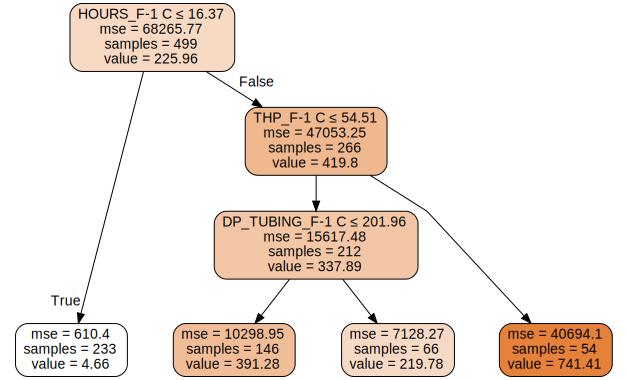

In [ ]:
draw_tree(m, X_train, size=10, leaves_parallel=True, precision=2)

The basis of the Decision Tree model is _bisection_, where we split the data in two and then we split it further until the maximum leaf nodes (`max_leaf_nodes`).

First Node / Leaf:
- From this particular Decision Tree that we display above, the model starts off with getting an average value of the whole 1996 samples/entries (total sample size of our training data)
- We get the average value of 7436 bopd (remember, this is `OilPlatform` values).
    - In other words, the baseline prediction of the model is the average values of the Y's in the training set. 
- The MSE is the statistical calculation "mean-squared-error", defined as 
$ MSE = \frac{1}{n} \sum \limits _{i=1} ^{n} ( y_i - \hat{y_i} )^2$,
where:
     * $y_i$ is the Actual y-values,
     * $\hat{y_i}$ is the Predicted y-values,
     * n is the total number of samples 
-At this juncture, the "question" that is to look at the data where `Well_4_WHT` <= 152.00 or not

Second Node (True):
- This is where the data is filtered to where `Well_4_WHT` is <= 152
- Total sample in this node is 1190.
- The "average Y" values in this node is 4412.33 bopd, which
- gives the MSE of 2655942.13

Second Node (False):
- This is where the data is filtered to where `Well_4_WHT` is > 152
- Total sample in this node is 1996 - 1190 = 806.
- The "average Y" values in this node is 11900.91 bopd, which
- gives the MSE of 4790017.93

and so forth........

We can also use dtreeviz to help us visualize it even better (adapted from `fastbook`):

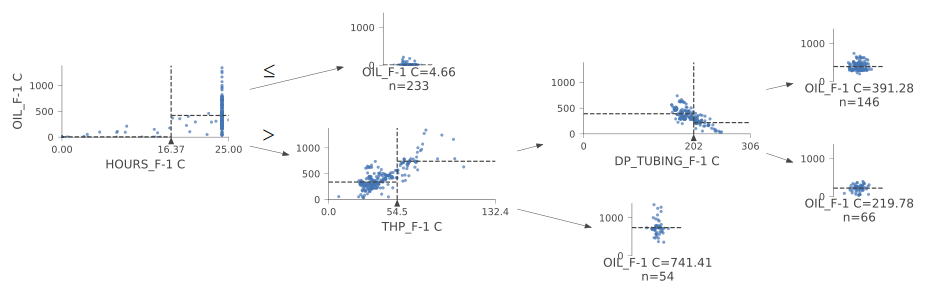

In [ ]:
samp_idx = np.random.permutation(len(y_train))[:500]
dtreeviz(m, X_train.iloc[samp_idx], y_train.iloc[samp_idx], X_train.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [ ]:
from sklearn.metrics import r2_score as r2, mean_absolute_error as mse 

print("Training R2: {}".format( round(r2(m.predict(X_train), y_train),2) ))
print("Training mse: {}".format( round(mse(m.predict(X_train), y_train),2) ))

Training R2: 0.99
Training mse: 10.16


We can see that the validation set has poorer performance; an indication that our tree is overfitting.

Let's build a bigger tree, without any passing in any stopping criteria such as `max_leaf_nodes`. In other words, the tree will be 'dissected' until it is left to 1 node.

In [ ]:
m = DecisionTreeRegressor()
m.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
print("Training mse: {}".format( round(mse(m.predict(X_train), y_train),2) ))
print("Training mse: {}".format( round(mse(m.predict(X_valid), y_valid),2) ))

Training mse: 10.16
Training mse: 28.7


It's quite obvious that the model would have zero errors for the training set since it was allowed to be further dissected until 1 node, but this is obviously overfitting because when we look at the validation set, the r^2 deteriorated.

### Random Forest

Random Forest is a machine learning model that are comprised of a bunch of 'bagged decision tree models'.

Imagine we have a number (`n_estimators`) of different DecisionTree models (like the one we created above), with each of them independently make a prediction on their own, based on different criterion that they independently decide (on the split of the columns/features), and we take the average of these mini-predictions as the ultimate prediction that we spit out of our RF model.

Note that some of these models may be super weak and some may have pretty good prediction on certain `x` inputs, but the average of these weak and strong models give us a very robust `y` prediction.

In [ ]:
# function adapted from fastbook

def rf(xs, y, n_estimators=20, max_samples=499,
       max_features=0.5, min_samples_leaf=2, **kwargs):
    
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True, ).fit(xs, y) 

#### `max_samples`
Below are the explanations (from <a href="https://stats.stackexchange.com/questions/347818/number-of-samples-per-tree-in-a-random-forest">StackExchange</a>) on `max_samples` and `bootstrap` options in `RandomForestRegressor` 

> If `bootstrap`=`False`, then each tree is built on all training samples.

> If `bootstrap`=`True`, then for each tree, N samples are drawn randomly with replacement from the training set and the tree is built on this new version of the training data. This introduces randomness in the training procedure since trees will each be trained on slightly different training sets. In expectation, drawing N samples with replacement from a dataset of size N will select ~2/3 unique samples from the original set. "

Note that RandomForestRegressor has bootstrap on by default, which means each N samples (affected by `max_samples`) drawn will be replaced back into the dataset.

#### `max_features`
> Defines how many columns to sample at each split point (where 0.5 means "take half the total number of columns") (source: fastbook)


#### `min_sample_leaf`
> Stopping criteria for when the tree reaches `min_sample_leaf` 

In [ ]:
random_state = 158

# fit the RF model
m = rf(X_train, y_train, random_state=random_state);

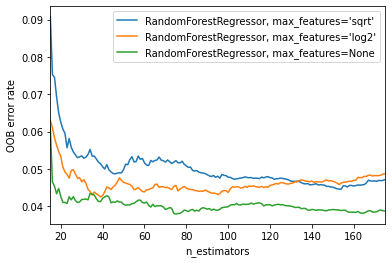

In [ ]:
from collections import OrderedDict

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=random_state)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=random_state)),
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=random_state))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

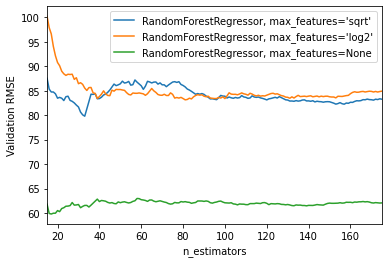

In [ ]:
from collections import OrderedDict

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=random_state)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=random_state)),
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=random_state))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the RMSE error on  the valid set for each `n_estimators=i` setting.
        RMSE = np.sqrt(mean_squared_error(y_valid, clf.predict(X_valid)))
        error_rate[label].append((i, RMSE))

# Generate the "RMSE validation error" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("Validation RMSE")
plt.legend(loc="upper right")
plt.show()

In [ ]:
m = RandomForestRegressor(n_estimators = 100, warm_start=True, max_features=None, oob_score=True, random_state=random_state)
m.fit(X_train, y_train)

print("Training rmse: {} stb/d".format( round ( np.sqrt(mean_squared_error(m.predict(X_train), y_train)),2) ))
print("Validation rmse: {} stb/d".format( round(np.sqrt(mean_squared_error(m.predict(X_valid), y_valid)),2) ))
print("OOB Error: {}".format( round ( (1 - m.oob_score_), 2)))

Training rmse: 18.97 stb/d
Validation rmse: 62.1 stb/d
OOB Error: 0.04


In [ ]:
m = RandomForestRegressor(n_estimators = 500, warm_start=True, max_features=None, oob_score=True, random_state=random_state)
m.fit(X_train, y_train)

print("Training rmse: {} stb/d".format( round ( np.sqrt(mean_squared_error(m.predict(X_train), y_train)),2) ))
print("Validation rmse: {} stb/d".format( round(np.sqrt(mean_squared_error(m.predict(X_valid), y_valid)),2) ))
print("OOB Error: {}".format( round ( (1 - m.oob_score_), 2)))

Training rmse: 17.83 stb/d
Validation rmse: 62.22 stb/d
OOB Error: 0.04


In [ ]:
m = RandomForestRegressor(n_estimators = 500, warm_start=True, min_samples_leaf=1, max_features=None, oob_score=True, random_state=random_state)
m.fit(X_train, y_train)

print("Training rmse: {} stb/d".format( round ( np.sqrt(mean_squared_error(m.predict(X_train), y_train)),2) ))
print("Validation rmse: {} stb/d".format( round(np.sqrt(mean_squared_error(m.predict(X_valid), y_valid)),2) ))
print("OOB Error: {}".format( round ( (1 - m.oob_score_), 2)))

Training rmse: 17.83 stb/d
Validation rmse: 62.22 stb/d
OOB Error: 0.04


### XGBoost

In [ ]:
from xgboost import XGBRegressor
from xgboost import DMatrix

In [ ]:
m_xgb = XGBRegressor(random_state=random_state)
m_xgb.fit(X_train, y_train)

print("Training rmse: {} stb/d".format( round ( np.sqrt(mean_squared_error(m_xgb.predict(X_train), y_train)),2) ))
print("Validation rmse: {} stb/d".format( round(np.sqrt(mean_squared_error(m_xgb.predict(X_valid), y_valid)),2) ))
# print("OOB Error: {}".format( round ( (1 - m.oob_score_), 2)))

[04:35:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training rmse: 15.53 stb/d
Validation rmse: 56.55 stb/d


In [ ]:
m_xgb = XGBRegressor(verbosity=1, max_depth=100, random_state=random_state)
m_xgb.fit(X_train, y_train)

print("Training rmse: {} stb/d".format( round ( np.sqrt(mean_squared_error(m_xgb.predict(X_train), y_train)),2) ))
print("Validation rmse: {} stb/d".format( round(np.sqrt(mean_squared_error(m_xgb.predict(X_valid), y_valid)),2) ))
# print("OOB Error: {}".format( round ( (1 - m.oob_score_), 2)))

[04:35:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training rmse: 0.35 stb/d
Validation rmse: 54.96 stb/d


In [ ]:
m_xgb = XGBRegressor(verbosity=1, max_depth=100, random_state=random_state, subsample=0.5 )
m_xgb.fit(X_train, y_train)

print("Training rmse: {} stb/d".format( round ( np.sqrt(mean_squared_error(m_xgb.predict(X_train), y_train)),2) ))
print("Validation rmse: {} stb/d".format( round(np.sqrt(mean_squared_error(m_xgb.predict(X_valid), y_valid)),2) ))
# print("OOB Error: {}".format( round ( (1 - m.oob_score_), 2)))

[04:35:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training rmse: 3.67 stb/d
Validation rmse: 51.35 stb/d


In [ ]:
m_xgb.get_params

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=100, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=158,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)>

In [ ]:
m_xgb = XGBRegressor(verbosity=1, max_depth=100, random_state=random_state, subsample=0.5, eval_metric = "rmse", evals=[])
m_xgb.fit(X_train, y_train)

print("Training rmse: {} stb/d".format( round ( np.sqrt(mean_squared_error(m_xgb.predict(X_train), y_train)),2) ))
print("Validation rmse: {} stb/d".format( round(np.sqrt(mean_squared_error(m_xgb.predict(X_valid), y_valid)),2) ))
# print("OOB Error: {}".format( round ( (1 - m.oob_score_), 2)))

[04:41:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training rmse: 3.67 stb/d
Validation rmse: 51.35 stb/d


In [ ]:
pred_valid = pd.DataFrame(m_xgb.predict(X_valid))
pred_train = pd.DataFrame(m_xgb.predict(X_train))

In [ ]:
pred_valid.shape

(247, 1)

In [ ]:
from sklearn import metrics

[Text(0, 0.5, 'y_valid'),
 Text(0.5, 0, 'Prediction'),
 Text(0.5, 1.0, 'Ground Truth vs Prediction')]

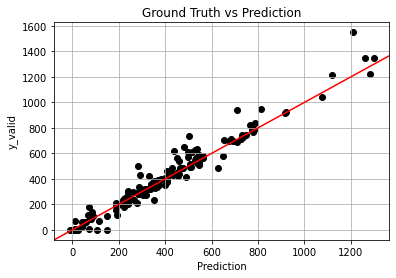

In [ ]:
fig, ax = plt.subplots()
from statsmodels.graphics.api import abline_plot

ax.scatter(pred_valid, y_valid, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax)
# ax[0].vlines(x=pred_valid.max(), ymin=y_valid.min(), color='red', linestyle='--', alpha=0.7, label="max error")
ax.grid(True)
ax.set(xlabel="Prediction", ylabel="y_valid", title="Ground Truth vs Prediction")

In [ ]:

def evaluate_model(alg, X_train, y_train, predictors, eval_metric='rmse'):
    
   
    #Fit the algorithm on the data
    alg.fit(X_train[predictors], y_train, eval_metric=eval_metric)
        
    #Predict training set:
    predictions = alg.predict(X_train[predictors])
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importance', color='g', figsize=(20,10)) 
    plt.ylabel('Feature Importance Score')
        
    #Print model report:
    print("\nModel Report")
    print("RMSE: %.4g" % np.sqrt(metrics.mean_squared_error(y_train, predictions)))

In [ ]:
m_xgb = XGBRegressor(random_state=random_state)

[05:41:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
RMSE: 15.53


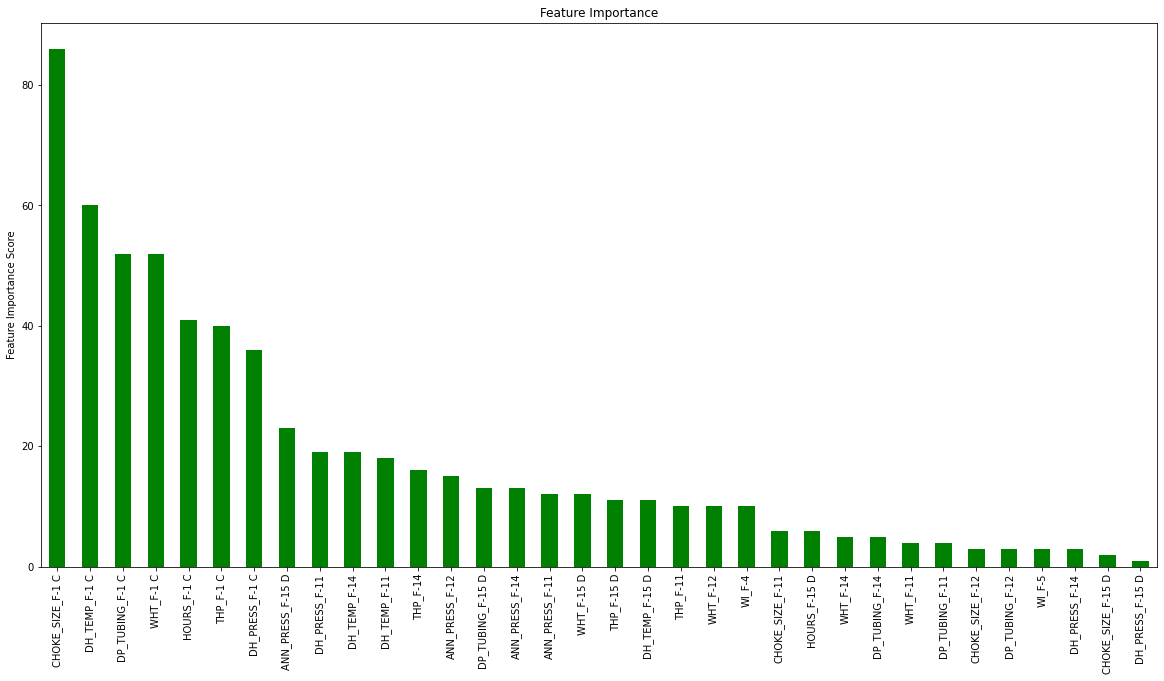

In [ ]:
evaluate_model(m_xgb, X_train, y_train, X_train.columns)

Reference: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f


In [ ]:
# load the pre-processed and split dataset (performed above)
X_train, X_valid, y_train, y_valid = load_pickle("total_preprocessed_data")
dep_var = 'OIL_F-1 C'

In [ ]:
import xgboost as xgb
from xgboost import DMatrix

In [ ]:
# converting datasets into DMatrix for better performance and speed
dtrain = DMatrix(X_train, label=y_train)
dvalid = DMatrix(X_valid, label=y_valid)

## Parameters

In [ ]:
# setting up the default parameters

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1, 
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

Reference: https://xgboost.readthedocs.io/en/latest/parameter.html

- `max_depth`: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 

- `min_child_weight`: 
  - Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. In linear regression task, this simply corresponds to minimum number of instances needed to be in each node. The larger min_child_weight is, the more conservative the algorithm will be.

- `eta` (alias `learning_rate`): Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.

- `subsample`: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.

- `colsample_bytree`:  is the subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

### Model Default Hyperparameters

Let us test out the model with the default setting of the hyperparameters

### Parameters `num_boost_round` and `early_stopping_rounds`

`num_boost_round` is the optimal number of boosting rounds or trees to build. It also corresponds to the maximum of boosting rounds that we will also allow the model to go. Its optimal value depends on other parameters and thus hsould be re-tuned each time you update a parameter. We can tune it together with all parameters in a grid-search, but it will be computationally expensive.

However, XGBoost provides a way to validate the performance of the model at each step and see if adding a new tree / round improves performance through `early_stopping_round`.

If the model performance has not improved in the validation set after `N` rounds from the `early_stopping_round` input, then it will stop the training.

In [ ]:
# adding and setting the evaluation metric to be root mean-squared-error.
params['eval_metric'] = 'rmse'

Setting the maximum number of boosting rounds that we allow. it should be large enough to allow the model to keep adding 'trees' if its performance keeps improving.

In [ ]:
# set the maximum of boosting rounds that we will allow:

num_boost_round = 999

We will now set the number of rounds for the model to keep adding trees before it stops as a result of non-improvement in its validation performance

In [ ]:
# N = 10 rounds as the condition to stop adding trees 
# if the model performance does not improve
early_stopping_rounds = 10

In [ ]:
model = xgb.train(params, 
                  dtrain=dtrain, 
                  num_boost_round=num_boost_round, 
                  evals=[(dvalid,"Valid")],
                  early_stopping_rounds=early_stopping_rounds)

[0]	Valid-rmse:298.687
Will train until Valid-rmse hasn't improved in 10 rounds.
[1]	Valid-rmse:225.239
[2]	Valid-rmse:173.497
[3]	Valid-rmse:139.026
[4]	Valid-rmse:115.086
[5]	Valid-rmse:97.4077
[6]	Valid-rmse:85.1654
[7]	Valid-rmse:76.2443
[8]	Valid-rmse:70.7415
[9]	Valid-rmse:67.5853
[10]	Valid-rmse:65.0388
[11]	Valid-rmse:62.9924
[12]	Valid-rmse:61.6847
[13]	Valid-rmse:60.5247
[14]	Valid-rmse:59.7678
[15]	Valid-rmse:59.1271
[16]	Valid-rmse:58.8383
[17]	Valid-rmse:58.5062
[18]	Valid-rmse:58.1969
[19]	Valid-rmse:58.0685
[20]	Valid-rmse:57.8384
[21]	Valid-rmse:57.7901
[22]	Valid-rmse:57.7517
[23]	Valid-rmse:57.5831
[24]	Valid-rmse:57.4259
[25]	Valid-rmse:57.4109
[26]	Valid-rmse:57.4371
[27]	Valid-rmse:57.4416
[28]	Valid-rmse:57.355
[29]	Valid-rmse:57.3332
[30]	Valid-rmse:57.3254
[31]	Valid-rmse:57.2639
[32]	Valid-rmse:57.2602
[33]	Valid-rmse:57.2487
[34]	Valid-rmse:57.219
[35]	Valid-rmse:57.2045
[36]	Valid-rmse:57.2016
[37]	Valid-rmse:57.1938
[38]	Valid-rmse:57.2122
[39]	Valid-rmse:57

The model stopped adding more trees / rounds after the 103th round as the RMSE was seen to not be improving anymore.

In [ ]:
print("Best RMSE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best RMSE: 57.00 with 103 rounds


## XGBoost CV (Cross Validation)
With XGBoost CV, we can use the existing training set for cross-validation.  The `nfold` is the number of hold-out sets (by random) for cross-validation. Since we are using CV, notice that we don't need an assigned validation set.  

The idea is to train our model parameters to minimize RMSE on cross-validation and then check the model performance on the actual validation set.

In [ ]:
def xgb_cv(params, dtrain, num_boost_round, seed, nfold, metric, early_stopping_rounds):
  cv_results = xgb.cv(params,
                    dtrain,
                    num_boost_round=num_boost_round,
                    seed=seed,
                    nfold=nfold,
                    metrics={metric},
                    early_stopping_rounds=early_stopping_rounds)
  return cv_results

In [ ]:
cv_results =xgb_cv(params, dtrain, num_boost_round, 158, 5, 'rmse', early_stopping_rounds)

cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,249.572571,4.812497,250.569409,23.610648
1,181.983493,3.284811,185.346124,20.384870
2,133.600748,2.243346,138.354636,17.964869
3,98.969339,1.530663,108.049684,14.892134
4,74.009575,1.000334,87.322475,14.251726
...,...,...,...,...
110,0.123345,0.075041,47.938808,9.713940
111,0.122925,0.075410,47.938693,9.713878
112,0.121988,0.076367,47.938541,9.714151
113,0.121371,0.076817,47.938366,9.714297


In [ ]:
cv_results["test-rmse-mean"].argmin()

114

## Parameters `max_depth` & `min_child_weight`
- both of these parameters are used to <u>**control the complexities of the trees**</u> and therefore should be tuned together

As referenced earlier:
- `max_depth` (default=6, 0 -> inf) is the maximum depth of a tree. The deeper the tree, the more complex the model will become and therefore can overfit to the noise of the model.
- `min_child_weight` (default=1, from 0 -> inf) is the minimum threshold weight  required for a node to be considered for further partitioning. If a node's weight is less than `min_child_weight`, then it will stop splitting. The lower the threshold, the most nodes that will be considered for partitioning, and therefore causing the model to be more complex (and thus overfit).  

In [ ]:
# create a gridsearch_parameters for max_depth & mind_child_weight
gridsearch_params = [ (max_depth, min_child_weight) for max_depth in range(6,12) for min_child_weight in range(1,8) ]

# initialize  min_rmse parameters best rmse
min_rmse = float('inf') 
# best_params dict to store best parameters found
best_params = {}

for max_depth, min_child_weight in gridsearch_params:
  print("XGB CV with max_depth = %s, min_child_weight = %s" % (max_depth, min_child_weight) )

  # update parameters for max_depth & min_child_weight
  params["max_depth"] = max_depth
  params["min_child_weight"] = min_child_weight

  # run xgb_cv
  cv_results = xgb_cv(params, dtrain, num_boost_round, 158, 5, "rmse", early_stopping_rounds)

  # get the lowest test-rmse-mean
  min_mean_rmse = cv_results["test-rmse-mean"].min()

  # get the corresponding index number of min_mean_rmse -> boost round / tree
  tree_rounds = cv_results["test-rmse-mean"].argmin()

  # print results
  print("\tRMSE %.4g stb/d for %s rounds" % (min_mean_rmse, tree_rounds))

  # compare to see which one is the best one so far
  if min_mean_rmse < min_rmse:
    min_rmse = min_mean_rmse
    best_params["max_depth"] = max_depth
    best_params["min_child_weight"] = min_child_weight

print("\n" + "*"*20 + "\nBest parameters\n" + "*"*20)
print("RMSE: %.4g stb/d" % min_rmse)
print("max_depth: %s, min_child_weight: %s" % (best_params["max_depth"], best_params["min_child_weight"]))

XGB CV with max_depth = 6, min_child_weight = 1
	RMSE 47.94 stb/d for 114 rounds
XGB CV with max_depth = 6, min_child_weight = 2
	RMSE 50.14 stb/d for 57 rounds
XGB CV with max_depth = 6, min_child_weight = 3
	RMSE 50.74 stb/d for 81 rounds
XGB CV with max_depth = 6, min_child_weight = 4
	RMSE 50.28 stb/d for 99 rounds
XGB CV with max_depth = 6, min_child_weight = 5
	RMSE 48.48 stb/d for 80 rounds
XGB CV with max_depth = 6, min_child_weight = 6
	RMSE 50.83 stb/d for 35 rounds
XGB CV with max_depth = 6, min_child_weight = 7
	RMSE 51.03 stb/d for 33 rounds
XGB CV with max_depth = 7, min_child_weight = 1
	RMSE 50.51 stb/d for 74 rounds
XGB CV with max_depth = 7, min_child_weight = 2
	RMSE 53.71 stb/d for 103 rounds
XGB CV with max_depth = 7, min_child_weight = 3
	RMSE 52.43 stb/d for 25 rounds
XGB CV with max_depth = 7, min_child_weight = 4
	RMSE 50.33 stb/d for 43 rounds
XGB CV with max_depth = 7, min_child_weight = 5
	RMSE 48.8 stb/d for 28 rounds
XGB CV with max_depth = 7, min_child_we

In [ ]:
# update parameters with the best one found
params["max_depth"] = best_params["max_depth"]
params["min_child_weight"] = best_params["min_child_weight"]

## Parameters `subsample` and `colsample_bytree`

Instead of sampling the whole set for training, we can set a ratio for the model to `subsample` for training, so that it will not "overfit" to the training set.

Similarly, for the columns, if we set `colsample_bytree` = 1 means that we will use all the columns for every tree. 

In [ ]:
# create a gridsearch for subsample and colsample
gridsearch_params = [ (subsample, colsample) for subsample in [i/10. for i in range(5,11)] for colsample in [i/10. for i in range(5,11)] ]

# initialize  min_rmse parameters best rmse
min_rmse = float('inf') 

for subsample, colsample in gridsearch_params:
  print("XGB CV with subsample = %s, colsample_bytree = %s" % (subsample, colsample) )

  # update parameters for max_depth & min_child_weight
  params["subsample"] = subsample
  params["colsample_bytree"] = colsample

  # run xgb_cv
  cv_results = xgb_cv(params, dtrain, num_boost_round, 158, 5, "rmse", early_stopping_rounds)

  # get the lowest test-rmse-mean
  min_mean_rmse = cv_results["test-rmse-mean"].min()

  # get the corresponding index number of min_mean_rmse -> boost round / tree
  tree_rounds = cv_results["test-rmse-mean"].argmin()

  # print results
  print("\tRMSE %.4g stb/d for %s rounds" % (min_mean_rmse, tree_rounds))

  # compare to see which one is the best one so far
  if min_mean_rmse < min_rmse:
    min_rmse = min_mean_rmse
    best_params["subsample"] = subsample
    best_params["colsample_bytree"] = colsample

print("\n" + "*"*20 + "\nBest parameters\n" + "*"*20)
print("RMSE: %.4g stb/d" % min_rmse)
print("subsample: %s, colsample_bytree: %s" % (best_params["subsample"], best_params["colsample_bytree"]))

XGB CV with subsample = 0.5, colsample_bytree = 0.5
	RMSE 60.89 stb/d for 19 rounds
XGB CV with subsample = 0.5, colsample_bytree = 0.6
	RMSE 59.92 stb/d for 22 rounds
XGB CV with subsample = 0.5, colsample_bytree = 0.7
	RMSE 57.78 stb/d for 21 rounds
XGB CV with subsample = 0.5, colsample_bytree = 0.8
	RMSE 56.88 stb/d for 58 rounds
XGB CV with subsample = 0.5, colsample_bytree = 0.9
	RMSE 56.84 stb/d for 40 rounds
XGB CV with subsample = 0.5, colsample_bytree = 1.0
	RMSE 52.41 stb/d for 45 rounds
XGB CV with subsample = 0.6, colsample_bytree = 0.5
	RMSE 57.86 stb/d for 25 rounds
XGB CV with subsample = 0.6, colsample_bytree = 0.6
	RMSE 56.63 stb/d for 31 rounds
XGB CV with subsample = 0.6, colsample_bytree = 0.7
	RMSE 57.75 stb/d for 25 rounds
XGB CV with subsample = 0.6, colsample_bytree = 0.8
	RMSE 55.91 stb/d for 24 rounds
XGB CV with subsample = 0.6, colsample_bytree = 0.9
	RMSE 53.14 stb/d for 20 rounds
XGB CV with subsample = 0.6, colsample_bytree = 1.0
	RMSE 54.77 stb/d for 25

In [ ]:
# update parameters
params["subsample"] = best_params["subsample"]
params["colsample_bytree"] = best_params["colsample_bytree"]

## Parameter `ETA` (alias: `learning_rate`)
After each boosting step, we directly get the weights of new features and `eta` shrinks the feature weights to make sure it is more so conservative

In [ ]:
# create a gridsearch for eta
gridsearch_params = [0.5, 0.3, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001]

# initialize  min_rmse parameters best rmse
min_rmse = float('inf') 

for eta in gridsearch_params:
  print("XGB CV with eta = %s" % eta )

  # update parameters for eta
  params["eta"] = eta
  
  # run xgb_cv
  cv_results = xgb_cv(params, dtrain, num_boost_round, 158, 5, "rmse", early_stopping_rounds)

  # get the lowest test-rmse-mean
  min_mean_rmse = cv_results["test-rmse-mean"].min()

  # get the corresponding index number of min_mean_rmse -> boost round / tree
  tree_rounds = cv_results["test-rmse-mean"].argmin()

  # print results
  print("\tRMSE %.4g stb/d for %s rounds" % (min_mean_rmse, tree_rounds))

  # compare to see which one is the best one so far
  if min_mean_rmse < min_rmse:
    min_rmse = min_mean_rmse
    best_params["eta"] = eta

print("\n" + "*"*20 + "\nBest parameters\n" + "*"*20)
print("RMSE: %.4g stb/d" % min_rmse)
print("eta: %s" % (best_params["eta"]))

XGB CV with eta = 0.5
	RMSE 47.59 stb/d for 14 rounds
XGB CV with eta = 0.3
	RMSE 45.5 stb/d for 26 rounds
XGB CV with eta = 0.2
	RMSE 46.63 stb/d for 26 rounds
XGB CV with eta = 0.1
	RMSE 44.81 stb/d for 70 rounds
XGB CV with eta = 0.05
	RMSE 46.1 stb/d for 182 rounds
XGB CV with eta = 0.01
	RMSE 44.85 stb/d for 830 rounds
XGB CV with eta = 0.005
	RMSE 46.38 stb/d for 998 rounds
XGB CV with eta = 0.001
	RMSE 147.5 stb/d for 998 rounds

********************
Best parameters
********************
RMSE: 44.81 stb/d
eta: 0.1


In [ ]:
params['eta'] = best_params['eta']

## Training with the updated Hyperparameters

In [ ]:
params

{'colsample_bytree': 0.9,
 'eta': 0.1,
 'eval_metric': 'rmse',
 'max_depth': 8,
 'min_child_weight': 6,
 'objective': 'reg:squarederror',
 'subsample': 0.9}

In [ ]:
model = xgb.train(params, dtrain, num_boost_round=num_boost_round, 
                  evals=[(dvalid, "Valid")], 
                  early_stopping_rounds=early_stopping_rounds)
print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Valid-rmse:367.417
Will train until Valid-rmse hasn't improved in 10 rounds.
[1]	Valid-rmse:338.37
[2]	Valid-rmse:312.233
[3]	Valid-rmse:287.435
[4]	Valid-rmse:265.826
[5]	Valid-rmse:245.721
[6]	Valid-rmse:227.695
[7]	Valid-rmse:210.424
[8]	Valid-rmse:195.706
[9]	Valid-rmse:181.668
[10]	Valid-rmse:168.861
[11]	Valid-rmse:157.673
[12]	Valid-rmse:146.976
[13]	Valid-rmse:137.919
[14]	Valid-rmse:129.658
[15]	Valid-rmse:122.226
[16]	Valid-rmse:115.65
[17]	Valid-rmse:109.554
[18]	Valid-rmse:104.136
[19]	Valid-rmse:99.0763
[20]	Valid-rmse:94.6987
[21]	Valid-rmse:91.1157
[22]	Valid-rmse:87.766
[23]	Valid-rmse:84.5242
[24]	Valid-rmse:82.0766
[25]	Valid-rmse:79.3643
[26]	Valid-rmse:76.9762
[27]	Valid-rmse:75.1337
[28]	Valid-rmse:73.1834
[29]	Valid-rmse:71.6893
[30]	Valid-rmse:70.4577
[31]	Valid-rmse:69.0009
[32]	Valid-rmse:67.872
[33]	Valid-rmse:67.0239
[34]	Valid-rmse:66.0515
[35]	Valid-rmse:65.0819
[36]	Valid-rmse:64.1277
[37]	Valid-rmse:63.1803
[38]	Valid-rmse:62.3789
[39]	Valid-rmse:62.1

## Finalizing and Saving Model:

We should finalize the model according to the number of rounds / trees found without the use of `early_stopping_round`

In [ ]:
num_boost_round = model.best_iteration+1

best_xgb = xgb.train(params, dtrain, num_boost_round, evals=[(dvalid, "Valid")])

[0]	Valid-rmse:367.417
[1]	Valid-rmse:338.37
[2]	Valid-rmse:312.233
[3]	Valid-rmse:287.435
[4]	Valid-rmse:265.826
[5]	Valid-rmse:245.721
[6]	Valid-rmse:227.695
[7]	Valid-rmse:210.424
[8]	Valid-rmse:195.706
[9]	Valid-rmse:181.668
[10]	Valid-rmse:168.861
[11]	Valid-rmse:157.673
[12]	Valid-rmse:146.976
[13]	Valid-rmse:137.919
[14]	Valid-rmse:129.658
[15]	Valid-rmse:122.226
[16]	Valid-rmse:115.65
[17]	Valid-rmse:109.554
[18]	Valid-rmse:104.136
[19]	Valid-rmse:99.0763
[20]	Valid-rmse:94.6987
[21]	Valid-rmse:91.1157
[22]	Valid-rmse:87.766
[23]	Valid-rmse:84.5242
[24]	Valid-rmse:82.0766
[25]	Valid-rmse:79.3643
[26]	Valid-rmse:76.9762
[27]	Valid-rmse:75.1337
[28]	Valid-rmse:73.1834
[29]	Valid-rmse:71.6893
[30]	Valid-rmse:70.4577
[31]	Valid-rmse:69.0009
[32]	Valid-rmse:67.872
[33]	Valid-rmse:67.0239
[34]	Valid-rmse:66.0515
[35]	Valid-rmse:65.0819
[36]	Valid-rmse:64.1277
[37]	Valid-rmse:63.1803
[38]	Valid-rmse:62.3789
[39]	Valid-rmse:62.1284
[40]	Valid-rmse:61.8695
[41]	Valid-rmse:61.4302
[42]	V

In [ ]:
print( "-> RMSE for the Best XGB model: %.4g stb/d" % np.sqrt(mean_squared_error(best_xgb.predict(dvalid), y_valid)) )

-> RMSE for the Best XGB model: 52.88 stb/d


In [ ]:
# save model
best_xgb.save_model("F1C_best_xgb.model")

## Feature Importance

In [ ]:
def feature_importance(model, dtrain, y_train, eval_metric='rmse'):

    #Predict training set:
    predictions = model.predict(dtrain)
    
    feat_imp = pd.Series(model.get_fscore()).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importance', color='g', figsize=(20,10)) 
    plt.ylabel('Feature Importance Score')
        
    #Print model report:
    print("\nModel Report")
    print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_train, predictions)))

In [ ]:
def feature_importance(model, dtrain, y_train, eval_metric='rmse', max_feature=None):

    #Predict training set:
    predictions = model.predict(dtrain)
    
    feat_imp = pd.Series(model.get_fscore()).sort_values(ascending=False)[:max_feature]
    feat_imp.plot(kind='bar', title='Feature Importance', color='g', figsize=(20,10))
    plt.ylabel('Feature Importance Score')
        
    #Print model report:
    print("\nModel Report")
    print("RMSE: %.4g" % np.sqrt(mean_squared_error(y_train, predictions)))

    return list(feat_imp.keys())


Model Report
RMSE: 4.03


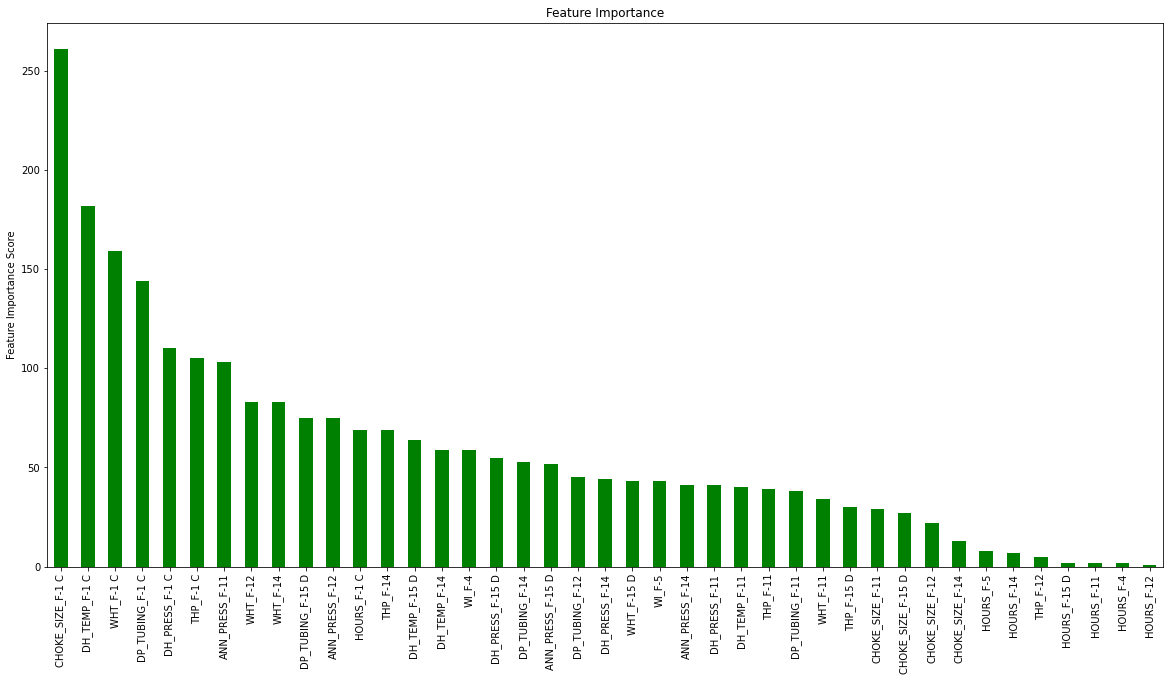

In [ ]:
# display all the feature_importance
feature_importance(best_xgb, dtrain, y_train)


Model Report
RMSE: 4.03


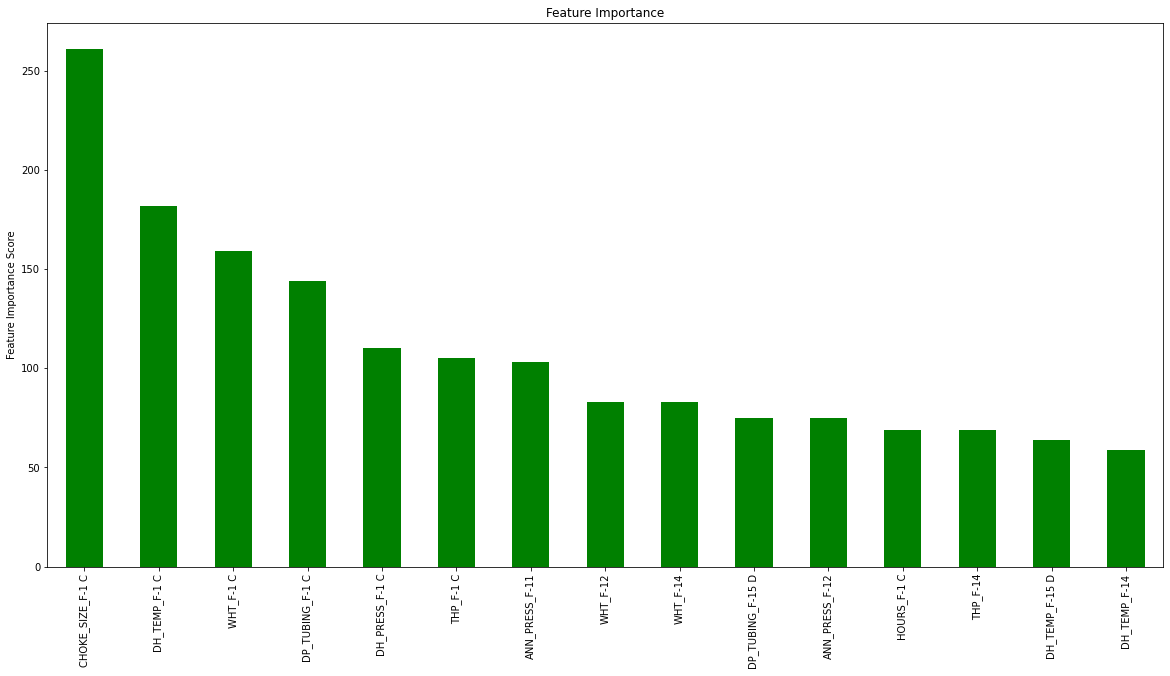

In [ ]:
# display & obtain the keys for the top 15 features
feat_top15 = feature_importance(best_xgb, dtrain, y_train, max_feature=15)

In [ ]:
feat_top15

['CHOKE_SIZE_F-1 C',
 'DH_TEMP_F-1 C',
 'WHT_F-1 C',
 'DP_TUBING_F-1 C',
 'DH_PRESS_F-1 C',
 'THP_F-1 C',
 'ANN_PRESS_F-11',
 'WHT_F-12',
 'WHT_F-14',
 'DP_TUBING_F-15 D',
 'ANN_PRESS_F-12',
 'HOURS_F-1 C',
 'THP_F-14',
 'DH_TEMP_F-15 D',
 'DH_TEMP_F-14']

[Text(0, 0.5, 'Actual Oil Production (stb/d)'),
 Text(0.5, 0, 'Predicted Oil Production (stb/d)'),
 Text(0.5, 1.0, 'Actual Oil Production vs Predicted Oil Production for OIL_F-1 C')]

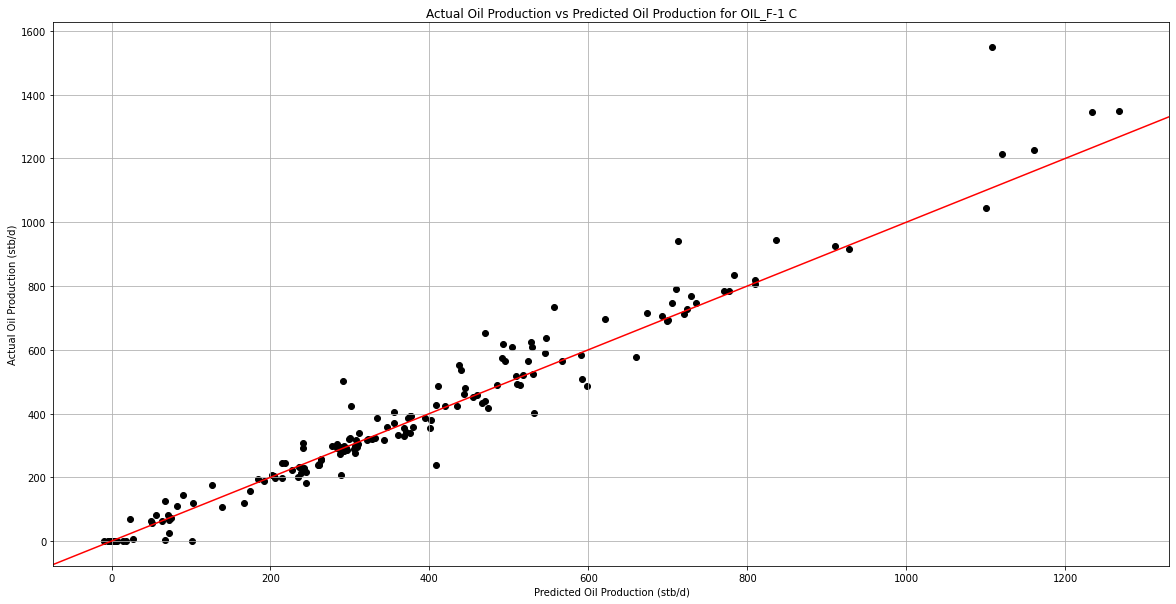

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
from statsmodels.graphics.api import abline_plot

ax.scatter(best_xgb.predict(dvalid), y_valid, color="black")
abline_plot(intercept=0, slope=1, color="red", ax=ax)
ax.grid(True)
ax.set(xlabel="Predicted Oil Production (stb/d)", ylabel="Actual Oil Production (stb/d)", title="Actual Oil Production vs Predicted Oil Production for {}".format(dep_var))

In [ ]:
prod_data = pd.read_excel("Volve production data.xlsx")

In [ ]:
prod_data

,HOURS_F-1 C,DH_PRESS_F-1 C,DH_TEMP_F-1 C,DP_TUBING_F-1 C,CHOKE_SIZE_F-1 C,THP_F-1 C,WHT_F-1 C,OIL_F-1 C,HOURS_F-11,DH_PRESS_F-11,DH_TEMP_F-11,DP_TUBING_F-11,ANN_PRESS_F-11,CHOKE_SIZE_F-11,THP_F-11,WHT_F-11,HOURS_F-12,DP_TUBING_F-12,ANN_PRESS_F-12,CHOKE_SIZE_F-12,THP_F-12,WHT_F-12,HOURS_F-14,DH_PRESS_F-14,DH_TEMP_F-14,DP_TUBING_F-14,ANN_PRESS_F-14,CHOKE_SIZE_F-14,THP_F-14,WHT_F-14,HOURS_F-15 D,DH_PRESS_F-15 D,DH_TEMP_F-15 D,DP_TUBING_F-15 D,ANN_PRESS_F-15 D,CHOKE_SIZE_F-15 D,THP_F-15 D,WHT_F-15 D,HOURS_F-4,WI_F-4,HOURS_F-5,WI_F-5
0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.0,3.50000,259.067489,104.968886,177.174594,3.684413,1.840619,81.892895,45.603218,5.00,34.457460,14.451638,10.994698,34.457460,82.159897,18.94167,260.684204,99.984888,225.574653,19.538645,59.631138,35.109551,83.267480,18.94167,206.971416,106.089329,159.692773,15.250262,10.023461,47.278643,26.435743,21.000,3509.000000,21.00000,2948.000000
1,0.0,240.637585,107.820459,182.849963,1.003059,0.00000,0.00000,0.0,24.00000,243.108703,105.824932,172.529655,18.535088,10.368586,70.579048,61.208645,24.00,31.725689,19.060333,99.901605,31.725689,90.141712,24.00000,255.671116,100.006185,223.431727,20.938670,100.000000,32.239388,87.991504,24.00000,199.909045,106.542361,154.748137,22.064371,12.620967,45.160908,29.903347,24.000,5995.272301,24.00000,4867.460113
2,0.0,240.637585,107.820459,182.849963,0.979008,0.00000,0.00000,0.0,24.00000,235.152372,106.201283,167.132686,25.392869,11.188099,68.019686,66.582405,24.00,32.147697,19.893729,99.963968,32.147697,90.755699,24.00000,255.926044,100.023921,223.535634,21.103206,100.000000,32.390409,88.303798,24.00000,200.106831,106.551857,154.718342,22.806857,12.452709,45.388489,32.298657,24.000,6409.375000,24.00000,6155.800000
3,0.0,240.637585,107.820459,182.849963,0.545759,0.00000,0.00000,0.0,21.95838,244.140768,106.052882,171.515172,22.462651,9.237663,72.625596,60.913619,21.96,32.314182,19.918978,82.836425,32.314182,90.358708,16.29166,261.779017,99.955707,225.999931,19.712599,60.394487,35.779087,84.243175,21.70833,203.133392,106.416076,156.611890,20.368019,11.134303,46.521501,29.687999,20.375,4327.183690,20.54167,4701.583677
4,0.0,310.376140,96.875890,277.278260,1.215987,33.09788,10.47992,0.0,24.00000,235.307363,106.295065,166.816553,26.863147,11.275121,68.490811,65.734842,24.00,32.409932,20.053109,99.950798,32.409932,90.306305,24.00000,255.917260,99.988281,223.400038,20.956191,100.000000,32.517222,87.932129,24.00000,200.078908,106.587505,154.656515,22.626104,12.336675,45.422393,31.534298,24.000,6066.184166,24.00000,6568.231369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,0.0,270.268490,101.198070,263.770350,0.000000,6.49814,9.80247,0.0,0.00000,295.890430,104.013740,241.914400,12.341320,0.908539,53.976030,16.363140,24.00,25.963390,21.328774,100.000000,25.963390,80.474954,24.00000,265.892421,99.619744,238.707001,22.287558,100.000000,27.185420,87.718003,24.00000,217.380685,106.507040,190.501459,22.338810,23.027926,26.879226,43.797356,24.000,8086.276001,0.00000,4458.448334
742,0.0,276.868950,101.231020,263.154980,0.000000,13.71397,11.74224,0.0,10.59153,285.247876,104.513498,248.705198,19.224793,14.241494,36.542678,60.783298,24.00,26.260906,21.346118,100.000000,26.260906,80.019092,24.00000,266.836270,99.618680,238.756777,22.242148,94.131284,28.079493,87.187158,24.00000,218.404099,106.474682,191.441157,21.149140,23.021921,26.962942,41.573982,24.000,7337.137283,0.00000,4458.448334
743,0.0,282.105380,101.177540,273.529590,0.265188,8.57579,10.11906,0.0,24.00000,270.864571,104.546627,242.223564,22.437392,100.000000,28.641007,82.518489,24.00,26.202680,21.224697,100.000000,26.202680,80.866471,24.00000,268.528664,99.595572,238.800927,22.103818,78.289675,29.727736,87.918535,24.00000,218.141422,106.472580,191.032221,21.001510,23.178127,27.109201,43.142941,24.000,6979.064483,0.00000,4458.448334
744,0.0,285.0957

## Save XGB Model

In [ ]:
# load model
loaded_model = xgb.Booster()
loaded_model.load_model("F1C_best_xgb.model")

# References

https://online.stat.psu.edu/stat200/lesson/3/3.2#:~:text=Any%20observations%20that%20are%20more,above%20Q3%20are%20considered%20outliers.